In [5]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
# Import MNIST data
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data/", one_hot=True)

Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


In [6]:
# Parameters
learning_rate = 0.001
training_epochs = 20
batch_size = 100
display_step = 1
e = np.array([1, 5, 10, 20, 30, 40, 50])
#e = np.array([10])
e_norm = e/256
save_images = False

# tf Graph Input
x = tf.placeholder(tf.float32, [None, 784]) # mnist data image of shape 28*28=784
y = tf.placeholder(tf.float32, [None, 10]) # 0-9 digits recognition => 10 classes
mask = tf.placeholder(tf.bool, [None]) # used to calculate acc. of only previously well-classified samples
epsilon = tf.placeholder_with_default(0.3, shape=())

# Set model weights
W1 = tf.Variable(tf.random_normal([784, 300], mean=0, stddev=1))
b1 = tf.Variable(tf.random_normal([300], mean=0, stddev = 1))

#W2 = tf.Variable(tf.random_normal([300, 100], mean=0, stddev= 1))
#b2 = tf.Variable(tf.random_normal([100], mean=0, stddev= 1))

W3 = tf.Variable(tf.zeros([300, 10]))
b3 = tf.Variable(tf.zeros([10]))

# Construct model
def dnn(x):
    hidden1 = tf.nn.relu(tf.matmul(x, W1) + b1); #first hidden layer
    #hidden2 = tf.nn.relu(tf.matmul(hidden1, W2) + b2); #second hidden layer
    pred = tf.nn.softmax(tf.matmul(hidden1, W3) + b3) # Softmax layer outputs prediction probabilities
    return pred

def FGSM(x, y, eps=epsilon, targeted=False):
    pred = dnn(x)
    cost = tf.reduce_mean(-tf.reduce_sum(y*tf.log(pred), reduction_indices=1))
    if targeted:
        cost= -cost
    gra, = tf.gradients(cost, x)
    gra_sign = tf.sign(gra)
    gra_sign = tf.stop_gradient(gra_sign)
    scaled_gra = epsilon * gra_sign
    adv_x = x + scaled_gra
    adv_x = tf.clip_by_value(adv_x, 0.0, 1.0)
    return adv_x
    
# Model output
pred = dnn(x)

# Minimize error using cross entropy 
cost = tf.reduce_mean(-tf.reduce_sum(y*tf.log(pred), reduction_indices=1))
optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost)

# Metrics
correct_prediction_mask = tf.equal(tf.argmax(pred, axis=1), tf.argmax(y, axis=1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction_mask, tf.float32))

pred_filtered = tf.boolean_mask(pred, mask)
y_filted = tf.boolean_mask(y, mask)
correct_prediction_mask_filtered = tf.equal(tf.argmax(pred_filtered, axis=1), tf.argmax(y_filted, axis=1))
accuracy_filtered = tf.reduce_mean(tf.cast(correct_prediction_mask_filtered, tf.float32))

Epoch: 01 cost= 0.567759048
Epoch: 02 cost= 0.365778276
Epoch: 03 cost= 0.328189541
Epoch: 04 cost= 0.308000321
Epoch: 05 cost= 0.293949633
Epoch: 06 cost= 0.283862431
Epoch: 07 cost= 0.275794536
Epoch: 08 cost= 0.270041145
Epoch: 09 cost= 0.264205001
Epoch: 10 cost= 0.259772651
Epoch: 11 cost= 0.255369939
Epoch: 12 cost= 0.252073512
Epoch: 13 cost= 0.248527613
Epoch: 14 cost= 0.245948698
Epoch: 15 cost= 0.243076370
Epoch: 16 cost= 0.241003052
Epoch: 17 cost= 0.238783221
Epoch: 18 cost= 0.236714529
Epoch: 19 cost= 0.235191307
Epoch: 20 cost= 0.233490911
Optimization Finished! 

Accuracy on original test samples: 0.9305 

FGSM:
Attack's success rate for UNTARGETED for epsilon = 1.0 is: 3.278 %
Attack's success rate for UNTARGETED for epsilon = 5.0 is: 28.587 %
Attack's success rate for UNTARGETED for epsilon = 10.0 is: 75.024 %
Attack's success rate for UNTARGETED for epsilon = 20.0 is: 99.624 %
Attack's success rate for UNTARGETED for epsilon = 30.0 is: 100.0 %
Attack's success rate fo

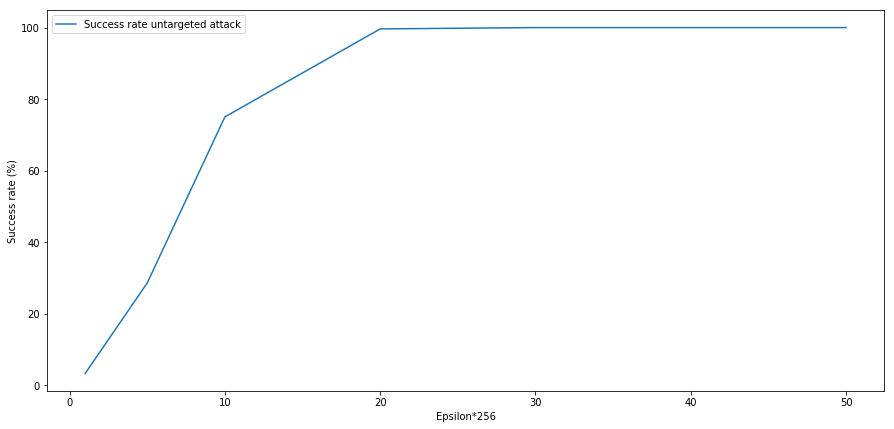

Attack's success rate for TARGETED for epsilon = 1.0 is: 0.204 %
Attack's success rate for TARGETED for epsilon = 5.0 is: 3.557 %
Attack's success rate for TARGETED for epsilon = 10.0 is: 23.461 %
Attack's success rate for TARGETED for epsilon = 20.0 is: 71.177 %
Attack's success rate for TARGETED for epsilon = 30.0 is: 86.889 %
Attack's success rate for TARGETED for epsilon = 40.0 is: 93.208 %
Attack's success rate for TARGETED for epsilon = 50.0 is: 96.679 %


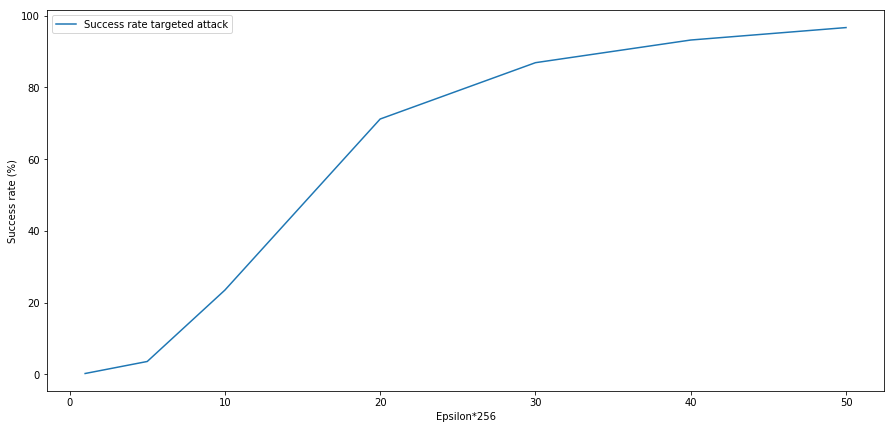

Comparison:


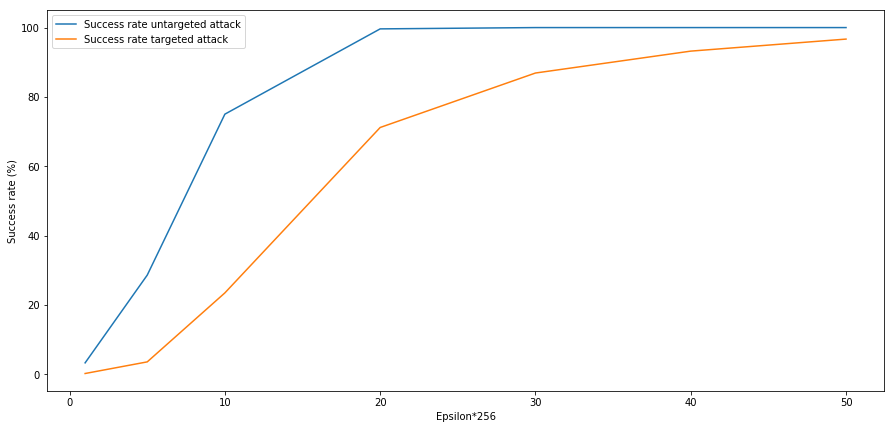


Creation of new datasets with adversarial examples...
Done


In [7]:
# Start training
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())

    # Training cycle
    for epoch in range(training_epochs):
        avg_cost = 0.
        total_batch = int(mnist.train.num_examples/batch_size)
        
        # Loop over all batches
        for i in range(total_batch):
            batch_xs, batch_ys = mnist.train.next_batch(batch_size)
            # Fit training using batch data
            _, c = sess.run([optimizer, cost], feed_dict={x: batch_xs, y: batch_ys})
            # Compute average loss
            avg_cost += c / total_batch
            
        # Display logs per epoch step
        if (epoch+1) % display_step == 0:
            print ("Epoch:", '%02d' % (epoch+1), "cost=", "{:.9f}".format(avg_cost))

    print ("Optimization Finished! \n")
    
    # Test model with original examples
    print ("Accuracy on original test samples:", sess.run(accuracy, {x: mnist.test.images, y: mnist.test.labels}), '\n')
    mask_correct = sess.run(correct_prediction_mask, {x: mnist.test.images, y: mnist.test.labels})
    
    succ_rate_untargated = []
    succ_rate_targated = []
    
    # FGSM manually coded
    print('FGSM:')
    #untargeted
    adv_x_untargeted = FGSM(x, y, epsilon, targeted=False)
    for ind, i in enumerate(e_norm):
        adv_X = sess.run(adv_x_untargeted, {x: mnist.test.images, y: mnist.test.labels, epsilon: i})
        #save images
        if save_images:
            for c in range(adv_X.shape[0]):
                plt.imsave('adv_im/untargeted/e' + str(int(i*256)) + '_adv_'+str(c)+'.png', adv_X[c].reshape(28, 28))
        succ_rate_untargated.append(round(100*(1 - sess.run(accuracy_filtered, {x: adv_X, y: mnist.test.labels, mask: mask_correct})), 3))
        print ("Attack's success rate for UNTARGETED for epsilon =", i*256, 'is:', succ_rate_untargated[ind], '%')
    
    fig = plt.figure(figsize=(15,7))
    plt.plot(e, succ_rate_untargated, label='Success rate untargeted attack')
    plt.xlabel("Epsilon*256")
    plt.ylabel("Success rate (%)")
    plt.legend()
    plt.savefig('fgsm_untargeted.png')
    plt.show()
    
    #targeted
    adv_x_targeted = FGSM(x, y, epsilon, targeted=True)
    target = np.roll(mnist.test.labels, 1, axis=1)
    for ind, i in enumerate(e_norm):
        adv_X = sess.run(adv_x_targeted, {x: mnist.test.images, y: target, epsilon: i})
        #save images
        if save_images:
            for c in range(adv_X.shape[0]):
                plt.imsave('adv_im/targeted/e' + str(int(i*256)) + '_adv_'+str(c)+'.png', adv_X[c].reshape(28, 28))
        succ_rate_targated.append(round(100*(sess.run(accuracy_filtered, {x: adv_X, y: target, mask: mask_correct})), 3))
        print ("Attack's success rate for TARGETED for epsilon =", i*256, "is:", succ_rate_targated[ind], '%')
        
    fig = plt.figure(figsize=(15,7))
    plt.plot(e, succ_rate_targated, label='Success rate targeted attack')
    plt.xlabel("Epsilon*256")
    plt.ylabel("Success rate (%)")
    plt.legend()
    plt.savefig('fgsm_targeted.png')
    plt.show()
    
    print('Comparison:')
    fig = plt.figure(figsize=(15,7))
    plt.plot(e, succ_rate_untargated, label='Success rate untargeted attack')
    plt.plot(e, succ_rate_targated, label='Success rate targeted attack')
    plt.xlabel("Epsilon*256")
    plt.ylabel("Success rate (%)")
    plt.legend()
    plt.savefig('fgsm_comparison.png')
    plt.show()
    
    # Adversarially retrained DNN
    #Create new dataset adding adv_x
    print('\nCreation of new datasets with adversarial examples...')
    x_new = {}
    for i in e_norm:
        adv_x_retrain = FGSM(x, y, epsilon, targeted=False)
        adv_X_retrain = adv_x_retrain.eval({x: mnist.train.images, y: mnist.train.labels, epsilon:i})
        x_new['e_{0}'.format(int(i*256))] = np.concatenate((mnist.train.images, adv_X_retrain), axis=0)
    y_new = np.concatenate((mnist.train.labels, mnist.train.labels), axis=0)    
    print('Done')  

Adversarial training with EPSILON= 1
Epoch: 01 cost= 0.463755969
Epoch: 02 cost= 0.323993339
Epoch: 03 cost= 0.294998419
Epoch: 04 cost= 0.281445417
Epoch: 05 cost= 0.270228451
Epoch: 06 cost= 0.257561127
Epoch: 07 cost= 0.251211417
Epoch: 08 cost= 0.245151247
Epoch: 09 cost= 0.244045898
Epoch: 10 cost= 0.241137635
Epoch: 11 cost= 0.241979737
Epoch: 12 cost= 0.230526748
Epoch: 13 cost= 0.229497338
Epoch: 14 cost= 0.225588941
Epoch: 15 cost= 0.231901428
Epoch: 16 cost= 0.228441575
Epoch: 17 cost= 0.224143486
Epoch: 18 cost= 0.223934431
Epoch: 19 cost= 0.223904867
Epoch: 20 cost= 0.217261815
Optimization Finished
Model saved in path: model/my_test_model
Accuracy of retrained model on original test samples: 93.09
Attack's success rate for UNTARGETED is: 3.738 %

Adversarial training with EPSILON= 5
Epoch: 01 cost= 0.480896650
Epoch: 02 cost= 0.329902349
Epoch: 03 cost= 0.304791738
Epoch: 04 cost= 0.284771520
Epoch: 05 cost= 0.268868545
Epoch: 06 cost= 0.266263908
Epoch: 07 cost= 0.2563254

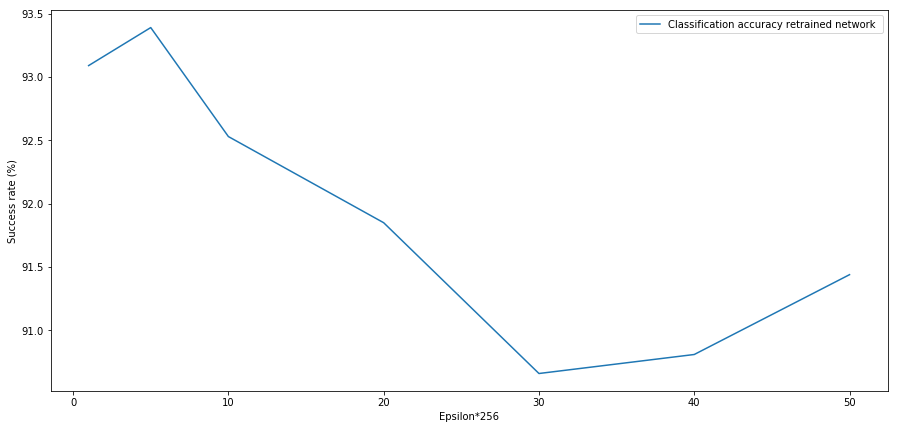

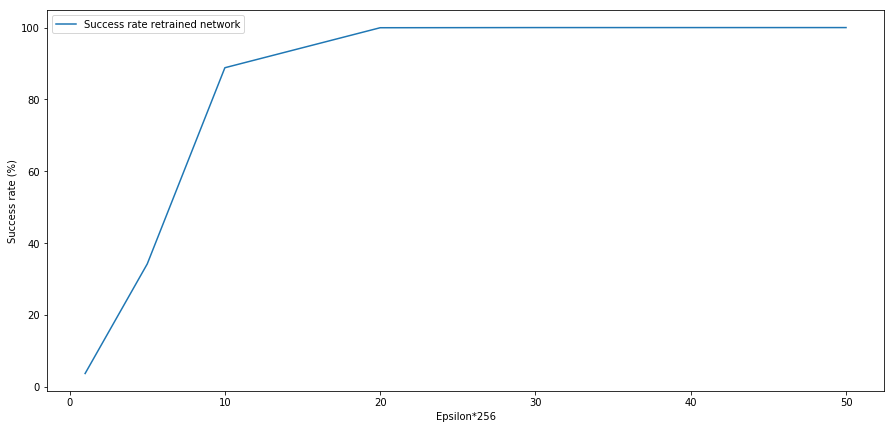

In [8]:
# 'Saver' saves and restores all the variables
saver = tf.train.Saver()

# Start adversarial training
with tf.Session() as sess_retrain:
    acc_ret = []
    succ_rate_ret = []
    for i_ in e_norm:
        print("Adversarial training with EPSILON=", int(i_*256))
        sess_retrain.run(tf.global_variables_initializer())
        # Parameters of retrain-session
        size_of_dataSet = x_new['e_{0}'.format(int(i_*256))].shape[0]
        indexes = np.arange(size_of_dataSet)
        np.random.shuffle(indexes)

        # Training cycle
        for epoch in range(training_epochs):
            avg_cost = 0.
            total_batch = int(size_of_dataSet/batch_size)

            # Loop over all batches
            for i in range(total_batch):
                random_indexes_train = np.random.choice(indexes, batch_size)
                batch_xs, batch_ys = x_new['e_{0}'.format(int(i_*256))][random_indexes_train], y_new[random_indexes_train]
                # Fit training using batch data
                _, c = sess_retrain.run([optimizer, cost], feed_dict={x: batch_xs, y: batch_ys})
                # Compute average loss
                avg_cost += c / total_batch

            # Display logs per epoch step
            if (epoch+1) % display_step == 0:
                print ("Epoch:", '%02d' % (epoch+1), "cost=", "{:.9f}".format(avg_cost))

        print ("Optimization Finished")
        
        save_path = saver.save(sess_retrain, "model/my_test_model")
        print("Model saved in path: %s" % save_path)
        
        # Test model with clean samples:
        acc_ret.append(round(100*sess_retrain.run(accuracy, {x: mnist.test.images, y: mnist.test.labels}), 3))
        print ("Accuracy of retrained model on original test samples:", acc_ret[-1])
        mask_correct = sess_retrain.run(correct_prediction_mask, {x: mnist.test.images, y: mnist.test.labels})
        
        # Attack the retrained model
        #Create adv_x
        adv_x_ret = FGSM(x, y, epsilon, targeted=False)
        adv_X = sess_retrain.run(adv_x_ret, {x: mnist.test.images, y: mnist.test.labels, epsilon: i_})
        succ_rate_ret.append(round(100*(1 - sess_retrain.run(accuracy_filtered, {x: adv_X, y: mnist.test.labels, mask: mask_correct})), 3))
        print ("Attack's success rate for UNTARGETED is:", succ_rate_ret[-1], '%\n')
        
    fig = plt.figure(figsize=(15,7))
    plt.plot(e, acc_ret, label='Classification accuracy retrained network ')
    plt.xlabel("Epsilon*256")
    plt.ylabel("Success rate (%)")
    plt.legend()
    plt.savefig('acc_ret.png')
    plt.show()
    
    fig = plt.figure(figsize=(15,7))
    plt.plot(e, succ_rate_ret, label='Success rate retrained network')
    plt.xlabel("Epsilon*256")
    plt.ylabel("Success rate (%)")
    plt.legend()
    plt.savefig('suc_ret.png')
    plt.show()